# Practical Statistics for Data Scientists (R)
# Chapter 1. Exploratory Data Analysis
> (c) 2019 Peter C. Bruce, Andrew Bruce, Peter Gedeck

Import required packages.

In [1]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(vioplot)
library(corrplot)
library(gmodels)
library(matrixStats)


Attaching package: ‘dplyr’



The following objects are masked from ‘package:stats’:

    filter, lag



The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


Loading required package: sm


Warning message in system2("/usr/bin/otool", c("-L", shQuote(DSO)), stdout = TRUE):
“running command ''/usr/bin/otool' -L '/Users/petergedeck/opt/miniconda3/envs/sfds-all/lib/R/library/tcltk/libs//tcltk.so'' had status 1”

Package 'sm', version 2.2-5.6: type help(sm) for summary information


Loading required package: zoo



Attaching package: ‘zoo’



The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



corrplot 0.84 loaded



Attaching package: ‘matrixStats’



The following object is masked from ‘package:dplyr’:

    count



Import the datasets needed for chapter 1

In [2]:
PSDS_PATH <- file.path(dirname(dirname(getwd())))
 
state <- read.csv(file.path(PSDS_PATH, 'data', 'state.csv'))
dfw <- read.csv(file.path(PSDS_PATH, 'data', 'dfw_airline.csv'))
sp500_px <- read.csv(file.path(PSDS_PATH, 'data', 'sp500_data.csv.gz'), row.names=1)
sp500_sym <- read.csv(file.path(PSDS_PATH, 'data', 'sp500_sectors.csv'), stringsAsFactors = FALSE)
kc_tax <- read.csv(file.path(PSDS_PATH, 'data', 'kc_tax.csv.gz'))
lc_loans <- read.csv(file.path(PSDS_PATH, 'data', 'lc_loans.csv'))
airline_stats <- read.csv(file.path(PSDS_PATH, 'data', 'airline_stats.csv'), stringsAsFactors = FALSE)
airline_stats$airline <- ordered(airline_stats$airline, 
                                 levels=c('Alaska', 'American', 'Jet Blue', 'Delta', 'United', 'Southwest'))

# Estimates of Location
## Example: Location Estimates of Population and Murder Rates

In [3]:
# Table 1-2
state_asc <- state
state_asc[['Population']] <- formatC(state_asc[['Population']], format='d', digits=0, big.mark=',')
state_asc[1:8,]

State,Population,Murder.Rate,Abbreviation
Alabama,"4,779,736",5.7,AL
Alaska,"710,231",5.6,AK
Arizona,"6,392,017",4.7,AZ
Arkansas,"2,915,918",5.6,AR
California,"37,253,956",4.4,CA
Colorado,"5,029,196",2.8,CO
Connecticut,"3,574,097",2.4,CT
Delaware,"897,934",5.8,DE


In [4]:
mean(state[['Population']])
mean(state[['Population']], trim=0.1)
median(state[['Population']])

[1] 6162876

[1] 4783697

[1] 4436370

In [5]:
weighted.mean(state[['Murder.Rate']], w=state[['Population']])
library('matrixStats')
weightedMedian(state[['Murder.Rate']], w=state[['Population']])

[1] 4.445834

[1] 4.4

# Estimates of Variability

In [6]:
sd(state[['Population']])
IQR(state[['Population']])
mad(state[['Population']])

[1] 6848235

[1] 4847308

[1] 3849870

## Percentiles and Boxplots

In [7]:
quantile(state[['Murder.Rate']], p=c(.05, .25, .5, .75, .95))

5%   25%   50%   75%   95% 
1.600 2.425 4.000 5.550 6.510

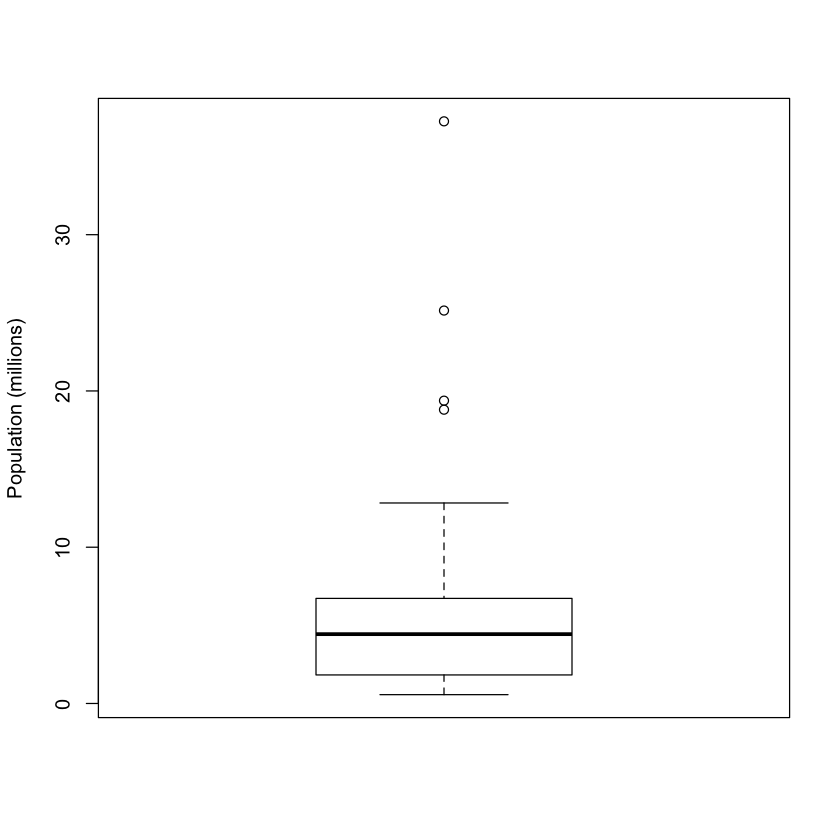

In [8]:
boxplot(state[['Population']]/1000000, ylab='Population (millions)')

## Frequency Table and Histograms

In [9]:
breaks <- seq(from=min(state[['Population']]), 
              to=max(state[['Population']]), length=11)
pop_freq <- cut(state[['Population']], breaks=breaks, 
                right=TRUE, include.lowest=TRUE)
state['PopFreq'] <- pop_freq
table(pop_freq)

pop_freq
[5.64e+05,4.23e+06]  (4.23e+06,7.9e+06]  (7.9e+06,1.16e+07] (1.16e+07,1.52e+07] 
                 24                  14                   6                   2 
(1.52e+07,1.89e+07] (1.89e+07,2.26e+07] (2.26e+07,2.62e+07] (2.62e+07,2.99e+07] 
                  1                   1                   1                   0 
(2.99e+07,3.36e+07] (3.36e+07,3.73e+07] 
                  0                   1 

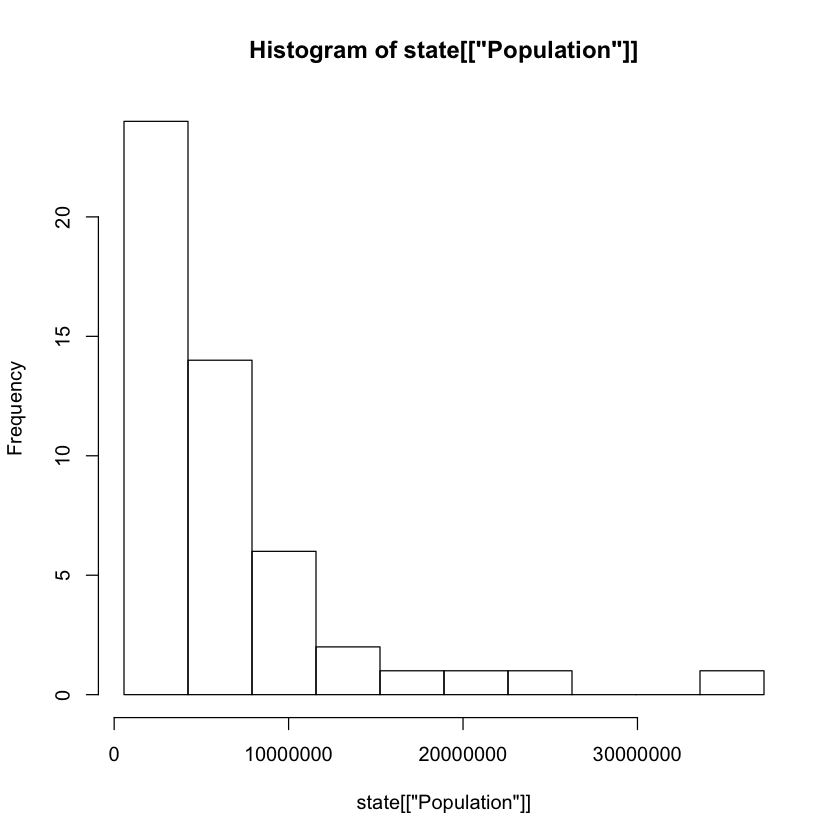

In [10]:
options(scipen=5)
hist(state[['Population']], breaks=breaks)

## Density Estimates
Density is an alternative to histograms that can provide more insight into the distribution of the data points. 

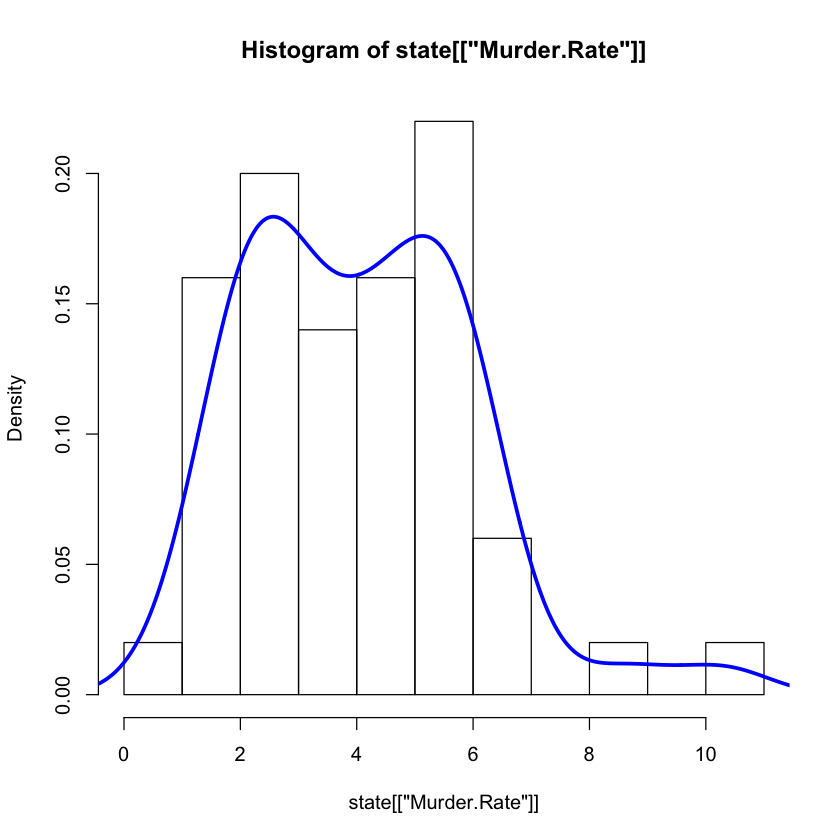

In [11]:
hist(state[['Murder.Rate']], freq=FALSE )
lines(density(state[['Murder.Rate']]), lwd=3, col='blue')

# Exploring Binary and Categorical Data

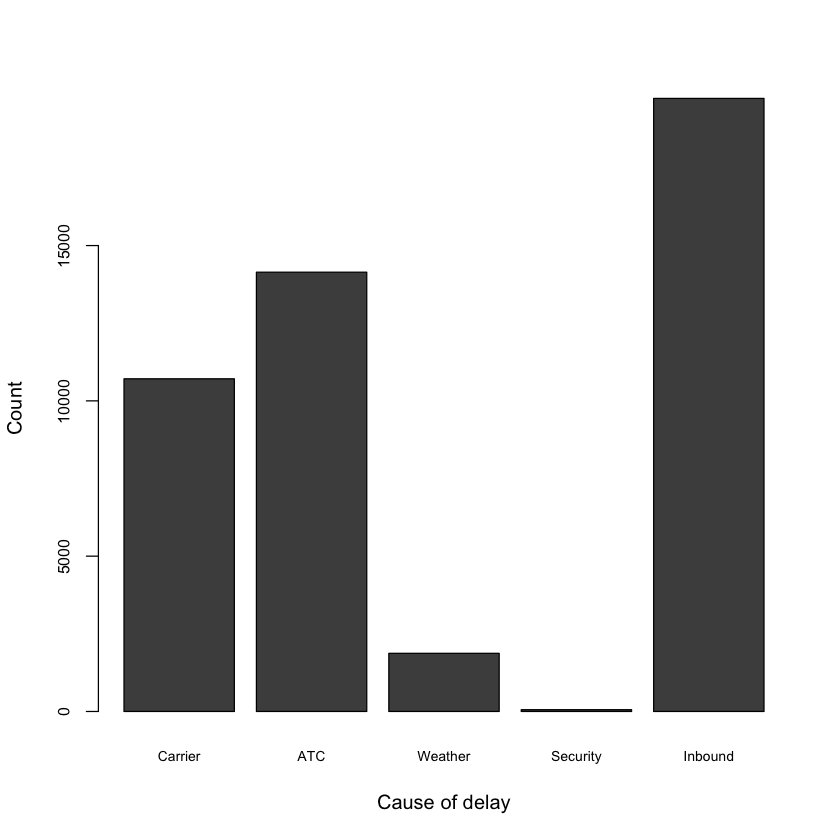

In [12]:
barplot(as.matrix(dfw) / 6, cex.axis=0.8, cex.names=0.7, 
        xlab='Cause of delay', ylab='Count')

# Correlation

In [13]:
telecom <- sp500_px[, sp500_sym[sp500_sym$sector == 'telecommunications_services', 'symbol']]
telecom <- telecom[row.names(telecom) > '2012-07-01',]
telecom_cor <- cor(telecom)

Next we focus on funds traded on major exchanges (sector == 'etf'). 

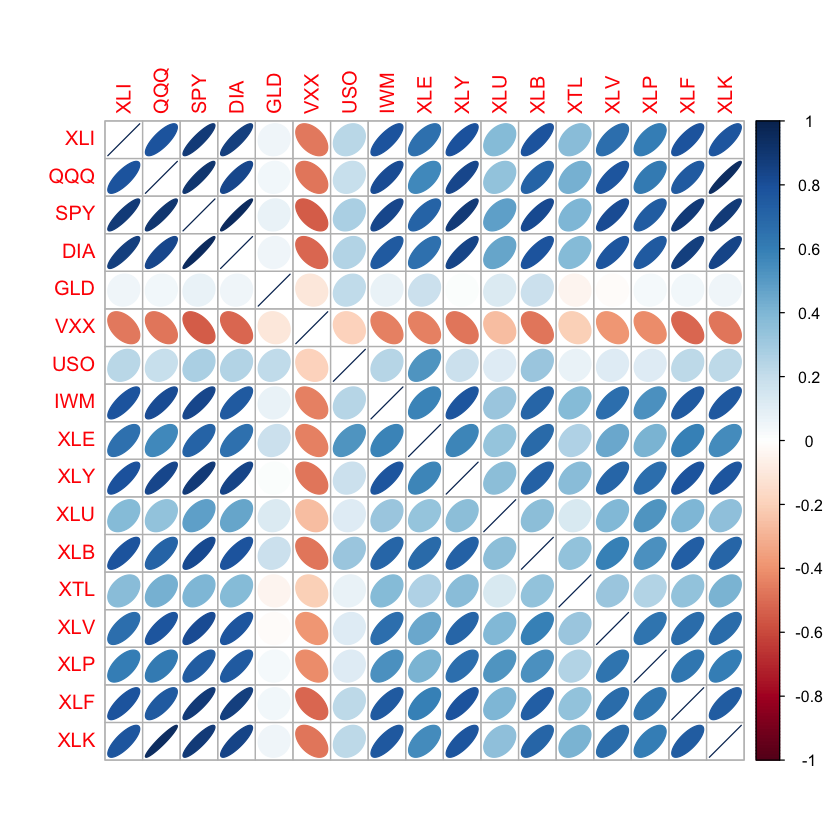

In [14]:
etfs <- sp500_px[row.names(sp500_px) > '2012-07-01', 
                 sp500_sym[sp500_sym$sector == 'etf', 'symbol']]
corrplot(cor(etfs), method='ellipse')

## Scatterplots

[1] 754   5

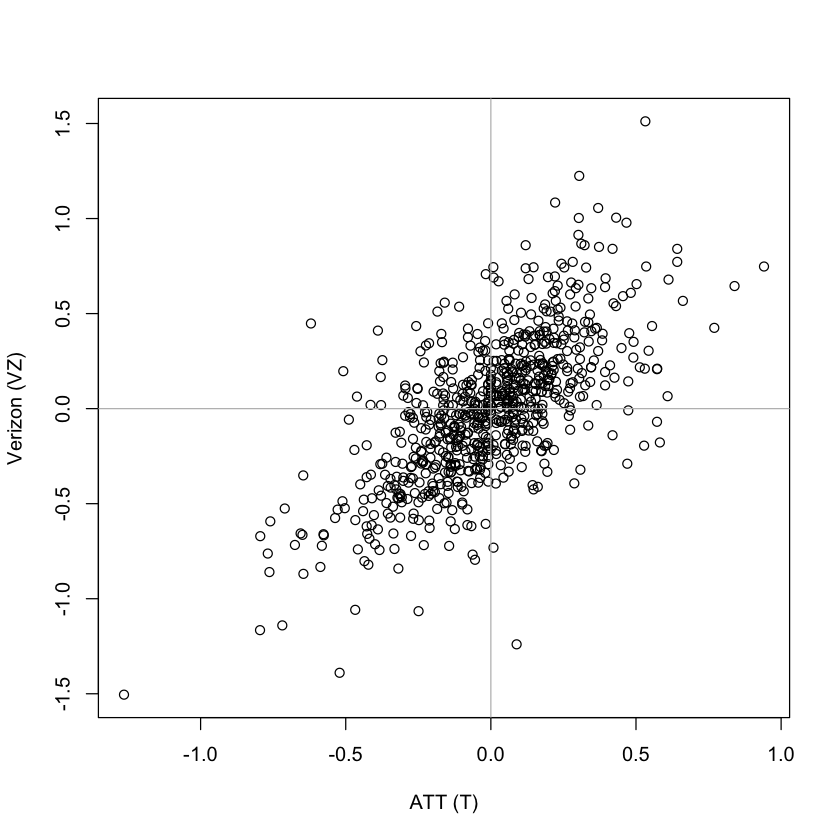

In [15]:
# plot(telecom$T, telecom$VZ, xlab='T', ylab='VZ', cex=.8)
plot(telecom$T, telecom$VZ, xlab='ATT (T)', ylab='Verizon (VZ)')
abline(h=0, v=0, col='grey')
dim(telecom)

# Exploring Two or More Variables
Load the kc_tax dataset and filter based on a variety of criteria

In [16]:
kc_tax0 <- subset(kc_tax, TaxAssessedValue < 750000 & 
                  SqFtTotLiving > 100 &
                  SqFtTotLiving < 3500)
nrow(kc_tax0)

[1] 432693

## Hexagonal binning and Contours 
### Plotting numeric versus numeric data

If the number of data points gets large, scatter plots will no longer be meaningful. Here methods that visualize densities are more useful. The `stat_hexbin` method for is one powerful approach.

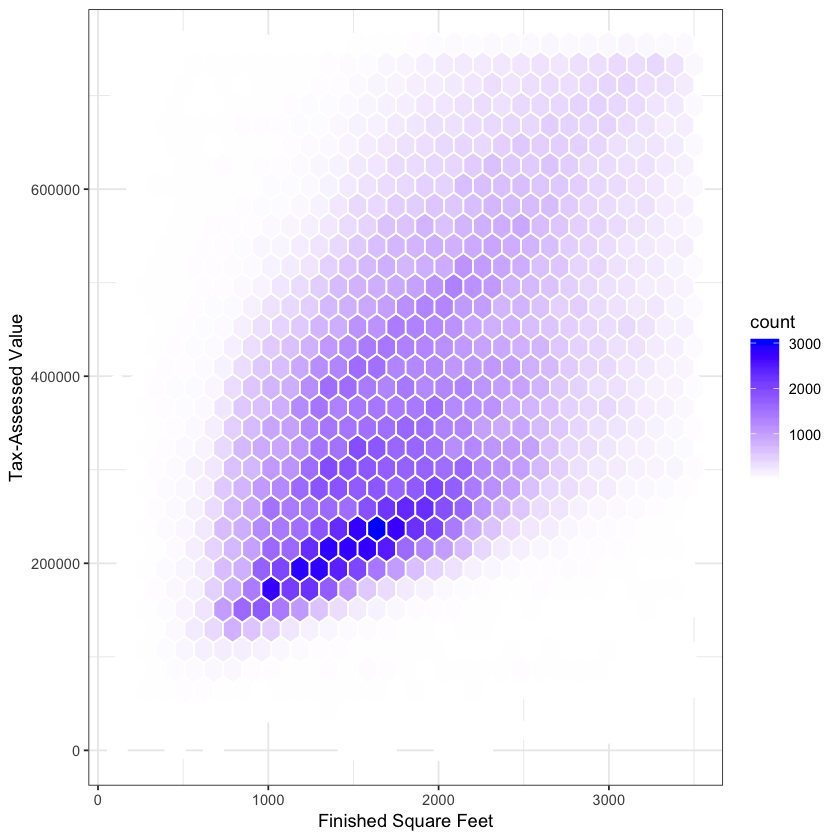

In [17]:
graph <- ggplot(kc_tax0, (aes(x=SqFtTotLiving, y=TaxAssessedValue))) + 
  stat_binhex(color='white') + 
  theme_bw() + 
  scale_fill_gradient(low='white', high='blue') +
  scale_y_continuous(labels = function(x) format(x, scientific = FALSE)) +
  labs(x='Finished Square Feet', y='Tax-Assessed Value')
graph

Visualize as a two-dimensional extension of the density plot. 

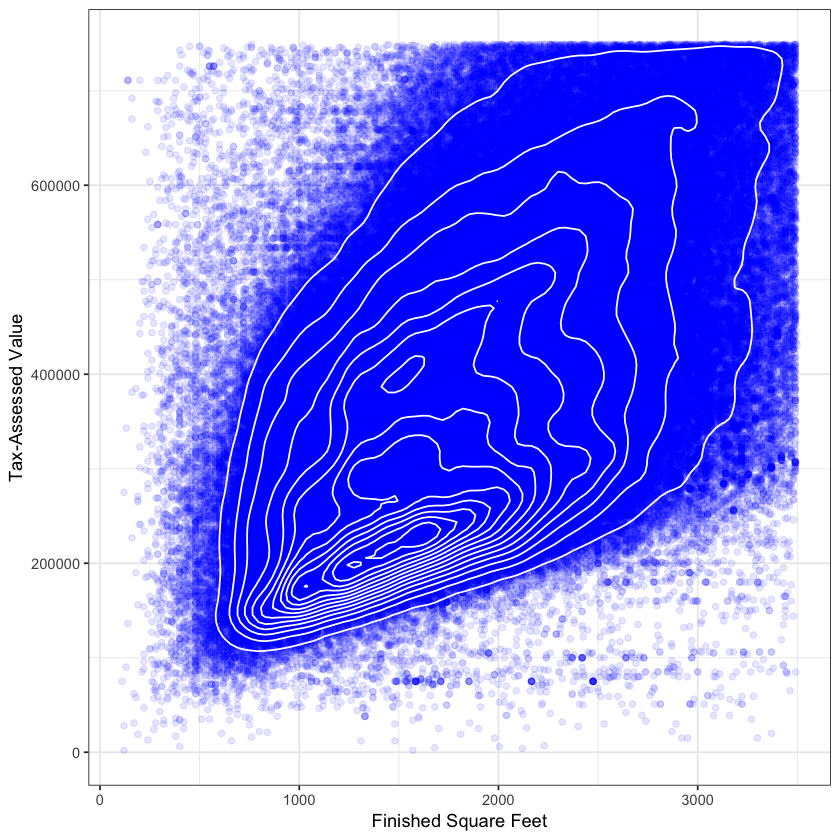

In [18]:
graph <- ggplot(kc_tax0, aes(SqFtTotLiving, TaxAssessedValue)) +
  theme_bw() + 
  geom_point(color='blue', alpha=0.1) + 
  geom_density2d(color='white') + 
  scale_y_continuous(labels = function(x) format(x, scientific = FALSE)) +
  labs(x='Finished Square Feet', y='Tax-Assessed Value')
graph

## Two Categorical Variables
Load the `lc_loans` dataset

In [19]:
x_tab <- CrossTable(lc_loans$grade, lc_loans$status, 
                    prop.c=FALSE, prop.chisq=FALSE, prop.t=FALSE)


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|-------------------------|

 
Total Observations in Table:  450961 

 
               | lc_loans$status 
lc_loans$grade | Charged Off |     Current |  Fully Paid |        Late |   Row Total | 
---------------|-------------|-------------|-------------|-------------|-------------|
             A |        1562 |       50051 |       20408 |         469 |       72490 | 
               |       0.022 |       0.690 |       0.282 |       0.006 |       0.161 | 
---------------|-------------|-------------|-------------|-------------|-------------|
             B |        5302 |       93852 |       31160 |        2056 |      132370 | 
               |       0.040 |       0.709 |       0.235 |       0.016 |       0.294 | 
---------------|-------------|-------------|-------------|-------------|-------------|
             C |        6023 |       88928 |       23147 |        2777 |      120875 | 
 

## Categorical and Numeric Data
Boxplots of a column can be grouped by a different column.

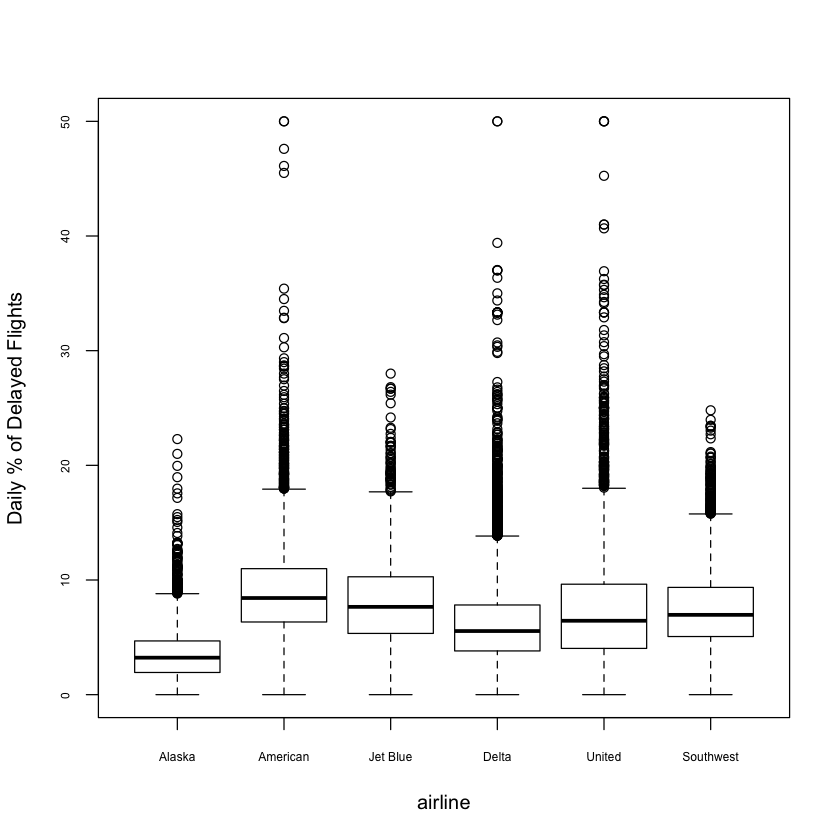

In [20]:
boxplot(pct_carrier_delay ~ airline, data=airline_stats, ylim=c(0, 50), 
        cex.axis=.6, ylab='Daily % of Delayed Flights')

Variation of boxplots called _violinplot_. 

Warning message:
“Removed 38 rows containing non-finite values (stat_ydensity).”

Warning message:
“Removed 38 rows containing non-finite values (stat_ydensity).”

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”

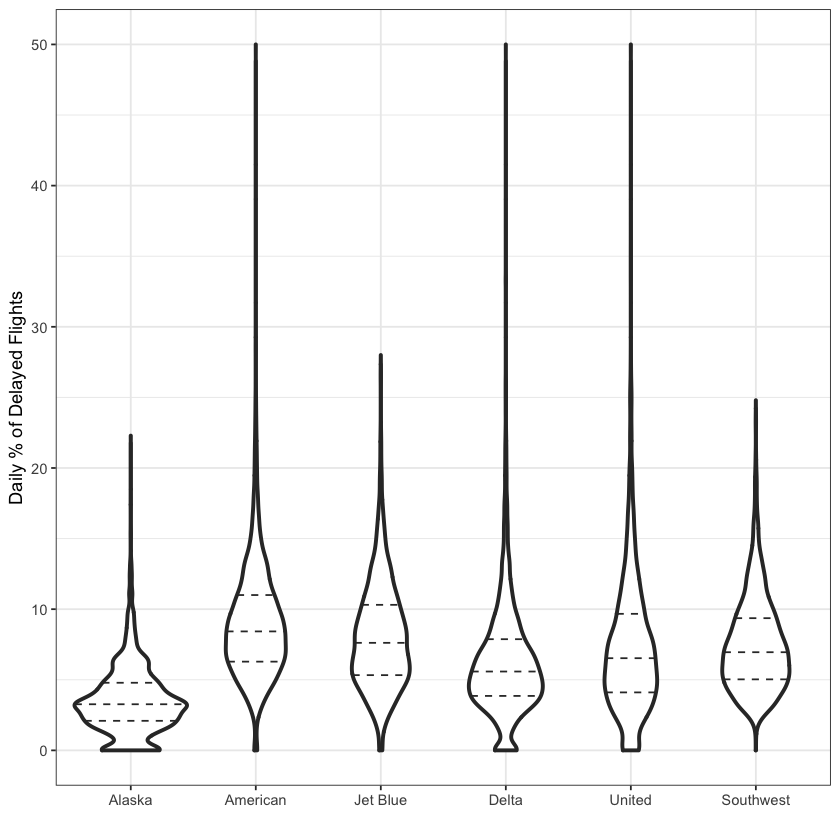

In [21]:
graph <- ggplot(data=airline_stats, aes(airline, pct_carrier_delay)) + 
  ylim(0, 50) + 
  geom_violin(draw_quantiles = c(.25,.5,.75), linetype=2) +
  geom_violin(fill=NA, size=1.1) +
  labs(x='', y='Daily % of Delayed Flights') +
  theme_bw()
graph

## Visualizing Multiple Variables

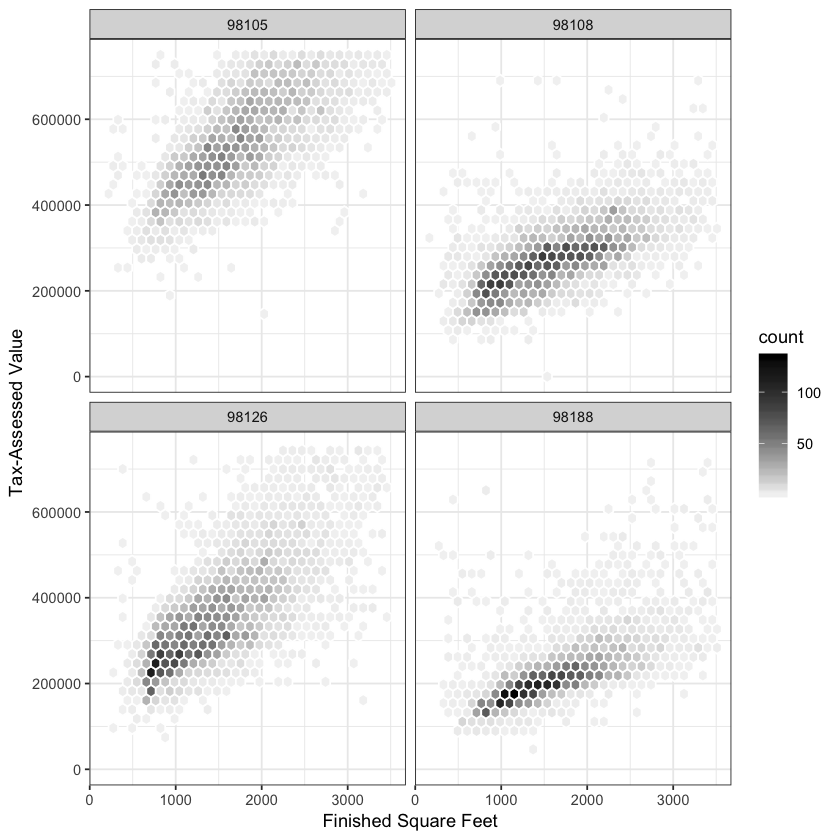

In [22]:
graph <- ggplot(subset(kc_tax0, ZipCode %in% c(98188, 98105, 98108, 98126)),
                aes(x=SqFtTotLiving, y=TaxAssessedValue)) + 
  stat_binhex(colour='white') + 
  theme_bw() + 
  scale_fill_gradient(low='gray95', high='black') +
  scale_y_continuous(labels = function(x) format(x, scientific = FALSE)) +
  labs(x='Finished Square Feet', y='Tax-Assessed Value') +
  facet_wrap('ZipCode')
graph